# Data Exploration and Cleaning

In [121]:
# Import all important Modules
import pandas as pd
import matplotlib.pyplot as plt
import os
from collections import Counter
import geopandas as gpd
import numpy as np

import pandana as pdna
import time

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score


In [82]:
# Pandana currently uses depreciated parameters in matplotlib, this hides the warning until its fixed
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [22]:
data_dir = r'./berlin-airbnb-data/listings_summary.csv'

good_features = [
                    'id', 'host_has_profile_pic', 'neighbourhood_group_cleansed',
                    'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
                    'bedrooms', 'bed_type', 'square_feet', 'price', 'cleaning_fee',
                    'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
                    'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'beds','amenities'
                ]

dataset = pd.read_csv(data_dir, usecols=good_features)


In [23]:
# print number of attributes and features
attributes = dataset.shape[1]
features = dataset.shape[0]
print(attributes)
print(features)

23
22552


Auf Basis der Literaturrecherche wurden 23 Features identifiziert, die in der Analyse mit aufgenommen werden sollen.
Momentan besitzt das Datenset 22552 Listings über ganz Berlin verteilt. Erster Schritt ist nun zu überprüfen, welche Features überwiegend leer sind.

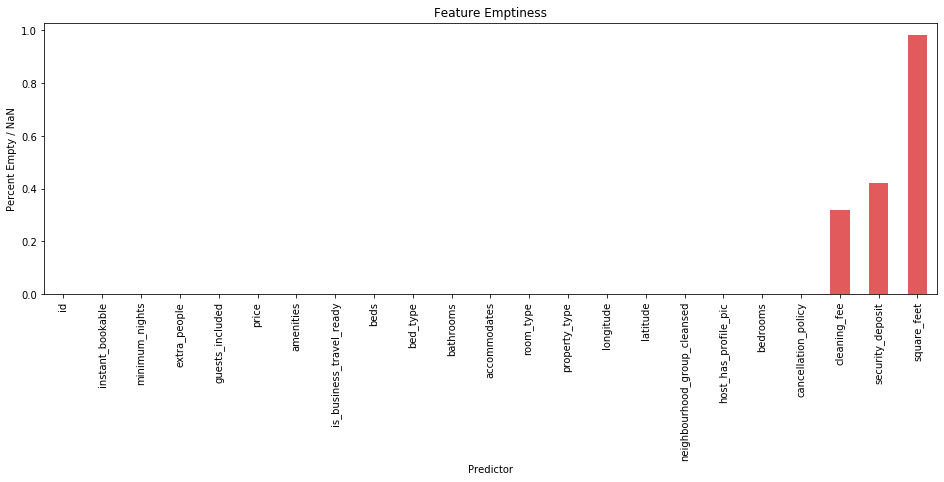

In [24]:
def percent_empty(df):
    bools = df.isnull().tolist()
    percent_empty = float(bools.count(True)) / float(len(bools))

    return percent_empty, float(bools.count(True))


# Store emptiness for all features
emptiness = []

missing_columns = []

# Get emptiness for all features
for i in range(0, dataset.shape[1]):
    p, n = percent_empty(dataset.iloc[:, i])
    if n > 0:
        missing_columns.append(dataset.columns.values[i])
    emptiness.append(round((p), 2))

empty_dict = dict(zip(dataset.columns.values.tolist(), emptiness))

# Plot emptiness graph
empty = pd.DataFrame.from_dict(empty_dict, orient='index').sort_values(by=0)
ax = empty.plot(kind='bar', color='#E35A5C', figsize=(16, 5))
ax.set_xlabel('Predictor')
ax.set_ylabel('Percent Empty / NaN')
ax.set_title('Feature Emptiness')
ax.legend_.remove()


plt.show()

square_feet hat in über 90% der Fälle keine Daten --> muss entfernt werden. Cleaning_fee und security_deposit werden vorerst noch im Datenset behalten

In [25]:
# --> Square feet over 90% missing Data --> Has to be removed
dataset.drop('square_feet', axis=1, inplace=True)
missing_columns.remove('square_feet')
attributes = dataset.shape[1]
print(attributes)

22


Counter({'Friedrichshain-Kreuzberg': 5497, 'Mitte': 4631, 'Pankow': 3541, 'Neukölln': 3499, 'Charlottenburg-Wilm.': 1592, 'Tempelhof - Schöneberg': 1560, 'Lichtenberg': 688, 'Treptow - Köpenick': 595, 'Steglitz - Zehlendorf': 437, 'Reinickendorf': 247, 'Marzahn - Hellersdorf': 141, 'Spandau': 124})


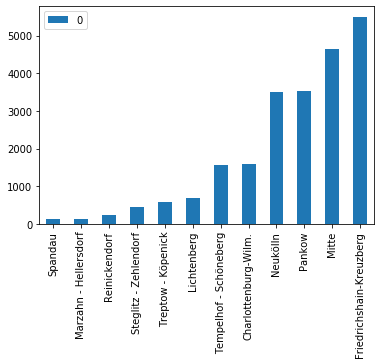

In [26]:
nb_counts = Counter(dataset.neighbourhood_group_cleansed)
df_nb = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
print(nb_counts)
df_nb.plot(kind='bar')
plt.show()


Die Neighbourhoods wurden in diesem Datenset bereits zusammengefasst. Eventuell kann man zu einem späteren Zeitpunkt diese nochmals überarbeiten, da diese Aufteilung auf die Stadtbezirke etwas grob ist.<br>
Der nächste Schritt ist nun sich die Datentypen der einzelnen Attribute näher anzuschauen, da für das spätere Modell nur numerische Datentypen verwendet werden können. 

In [27]:
# get datatypes of Dataset
print(dataset.dtypes)

id                                int64
host_has_profile_pic             object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
amenities                        object
price                            object
security_deposit                 object
cleaning_fee                     object
guests_included                   int64
extra_people                     object
minimum_nights                    int64
instant_bookable                 object
is_business_travel_ready         object
cancellation_policy              object
dtype: object


In [28]:
# Remove special Characters from Price, Safty-Deposit, Cleaning-Fee
dataset['cleaning_fee'] = dataset.cleaning_fee.str.replace("\$|,",'').astype(float)
dataset['security_deposit'] = dataset.security_deposit.str.replace("\$|,",'').astype(float)
dataset['price'] = dataset.price.str.replace("\$|,",'').astype(float)
dataset['extra_people'] = dataset.extra_people.str.replace("\$|,",'').astype(float)

Bevor die Kategorie-Variablen umgewandelt werden bietet es sich an diese nochmals zu überarbeiten und zusammenzufassen, damit im späteren Modell das Noise durch unnötige Dummie-Variablen verringert wird.

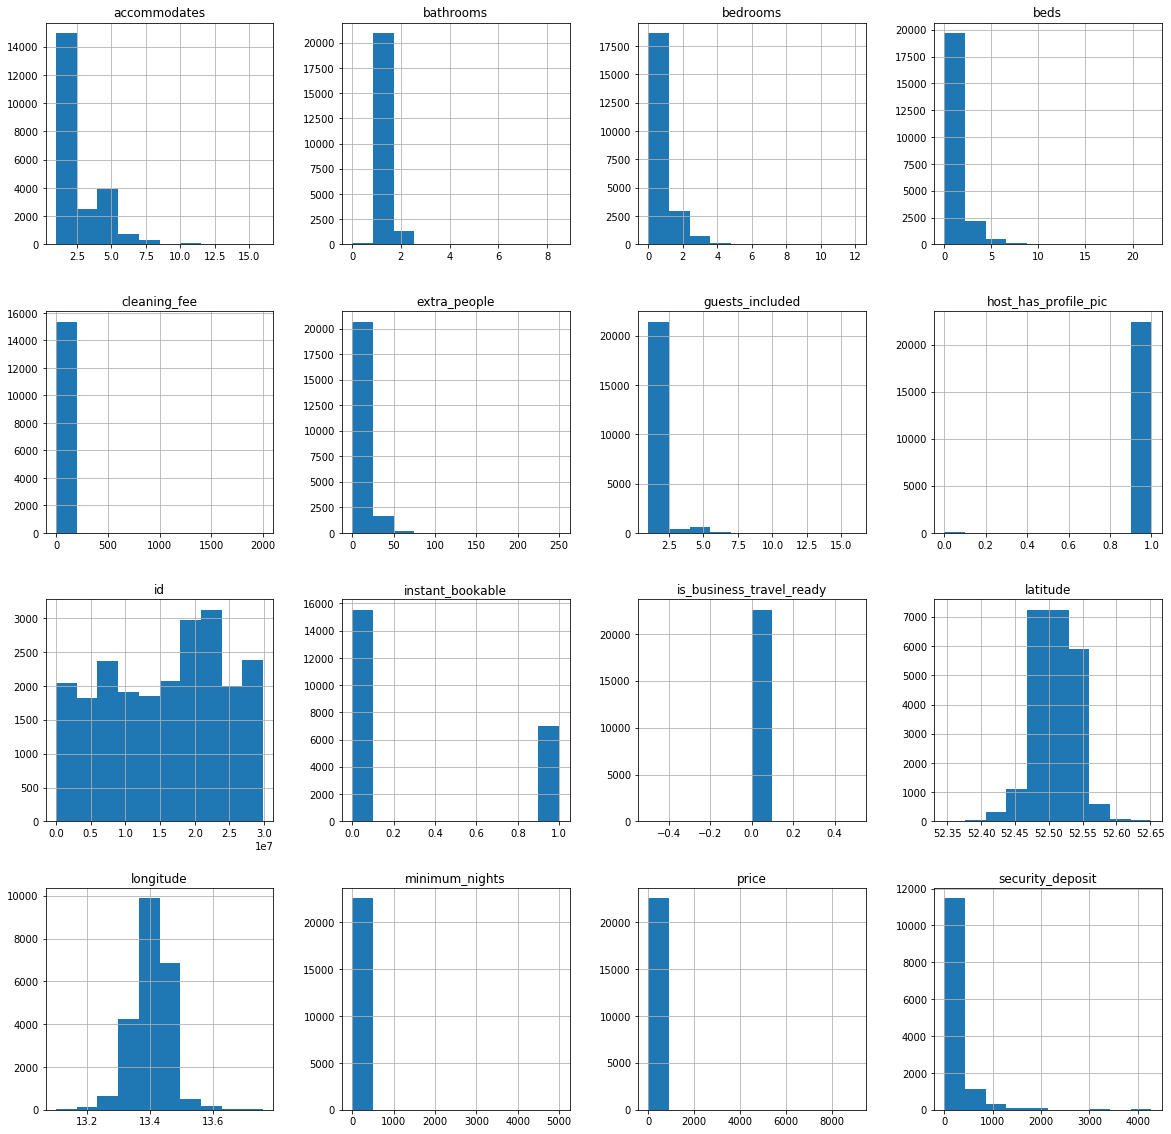

In [29]:
# Replacing columns with f/t with 0/1
dataset.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
dataset.hist(figsize=(20,20));

In [30]:
#From the above, it can be seen that several columns only contain one category and can be dropped:
dataset.drop(['is_business_travel_ready', 'host_has_profile_pic'], axis=1, inplace=True)

Feature Beschreibung:
property_type - type of property, e.g. house or flat
room_type - type of listing, e.g. entire home, private room or shared room
accommodates - how many people the property accommodates
bathrooms - number of bathrooms
bedrooms - number of bedrooms
beds - number of beds
bed_type - type of bed, e.g. real bed or sofa-bed
price - nightly advertised price (the target variable)
security_deposit - the amount required as a security deposit
cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
guests_included - the number of guests included in the booking fee
extra_people - the price per additional guest above the guests_included price
minimum_nights - the minimum length of stay


### Aufbereitung einzelner Attribute:

### Property_type

In [31]:
dataset.property_type.value_counts()

Apartment                 20225
Condominium                 612
Loft                        460
House                       398
Serviced apartment          175
Hostel                      128
Townhouse                    99
Guest suite                  74
Bed and breakfast            64
Guesthouse                   57
Hotel                        50
Other                        47
Boutique hotel               43
Bungalow                     20
Boat                         17
Tiny house                   12
Camper/RV                    11
Houseboat                    11
Villa                        10
Pension (South Korea)         7
Aparthotel                    7
Cabin                         6
Cottage                       4
Resort                        3
Castle                        2
Casa particular (Cuba)        2
Train                         2
Chalet                        1
In-law                        1
Cave                          1
Barn                          1
Tipi    

Das wird zu House, Apartment und other zusammengefasst.

In [32]:
# Replacing categories that are types of houses or apartments
dataset.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Condominium' : 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Chalet': 'House',
    'Houseboat':'House',
    'Castle':'House',
    'Casa particular (Cuba)': 'House'
    }, inplace=True)

# Replacing other categories with 'other'
dataset.loc[~dataset.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'
dataset.property_type.value_counts()

Apartment    21472
House          559
Other          521
Name: property_type, dtype: int64

### Price, Bathrooms, Beds and Accomadates

Droppe alle Features, die 0 als Value haben

In [33]:
dataset.bathrooms.value_counts()
dataset.beds.value_counts()
dataset.price.value_counts()
dataset.accommodates.value_counts() 

2     12228
4      3216
1      2734
3      2487
6       733
5       701
8       151
7       131
10       57
9        36
12       24
16       20
11       15
14       11
15        6
13        2
Name: accommodates, dtype: int64

In [34]:
dataset = dataset[dataset.price != 0]
dataset = dataset[dataset.bathrooms != 0]
dataset = dataset[dataset.accommodates != 0]
print(dataset.shape[1])
print(dataset.shape[0])

20
22503


### Bedtype

In [35]:
dataset.bed_type.value_counts()


Real Bed         21722
Pull-out Sofa      449
Futon              239
Couch               71
Airbed              22
Name: bed_type, dtype: int64

Kann eigentlich raus, da überwiegend der gleiche Bedtype angegeben wird (oder Fouton zu Bed und Pull-Out Sofa znd Airbed zu Couch)

In [36]:
dataset.bed_type.replace({
    'Futon':'Real Bed',
    'Pull-out Sofa': 'Couch',
    'Airbed':'Couch'
}, inplace=True)
dataset.bed_type.value_counts()


Real Bed    21961
Couch         542
Name: bed_type, dtype: int64

### Amenities

Kurzgefasst: Es gibt ewig viele, müssen ausgedünnt und zusammengefasst werden, wenn man später nicht 10000000-Dummie-Variablen haben möchte.

In [37]:
# Creating a set of all possible amenities
amenities_list = list(dataset.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First 

Aus dieser Liste sind manche wichtiger als andere, bspw. erhöht ein Pool den Preis mehr als ein Haartrockner. Durch die Literaturrecherche wurden folgende Amenities ausgwählt. Falls sich später herraustellen sollte, dass nur ein kleiner Anteil der Features diese besitzen sollten, werden sie wieder entfernt.

In [38]:
attributes = dataset.shape[1]
features = dataset.shape[0]
print(attributes)
print(features)

20
22503


In [39]:
# Create "Dummies" for the choosen amenities
dataset.loc[dataset['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
dataset.loc[dataset['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
dataset.loc[dataset['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
dataset.loc[dataset['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
dataset.loc[dataset['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
dataset.loc[dataset['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
dataset.loc[dataset['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
dataset.loc[dataset['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
dataset.loc[dataset['amenities'].str.contains('TV'), 'tv'] = 1
dataset.loc[dataset['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
dataset.loc[dataset['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
dataset.loc[dataset['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
dataset.loc[dataset['amenities'].str.contains('Elevator'), 'elevator'] = 1
dataset.loc[dataset['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
dataset.loc[dataset['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
dataset.loc[dataset['amenities'].str.contains('parking'), 'parking'] = 1
dataset.loc[dataset['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
dataset.loc[dataset['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
dataset.loc[dataset['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
dataset.loc[dataset['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
dataset.loc[dataset['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
dataset.loc[dataset['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
dataset.loc[dataset['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
dataset.loc[dataset['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
dataset.loc[dataset['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
dataset.loc[dataset['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
dataset.loc[dataset['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
dataset.loc[dataset['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [40]:
attributes = dataset.shape[1]
features = dataset.shape[0]
print(attributes)
print(features)

48
22503


Wie zuvor erwähnt, werden nun alle amenities wieder entfernt, die in weniger als 10% der Fälle vorhanden sind. Sonst könnte zu viel Noise entstehen.

In [41]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = dataset.iloc[:,21:].columns
dataset[cols_to_replace_nulls] = dataset[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in dataset.iloc[:,21:].columns:
    if dataset[col].sum() < len(dataset)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
dataset.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
dataset.drop('amenities', axis=1, inplace=True)

['air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'breakfast', 'gym', 'outdoor_space', 'hot_tub_sauna_or_pool', 'secure', 'self_check_in', 'accessible', 'event_suitable']


### All Attributes containing a Price

Diese wurden zuvor schon von einem String zu float umgewandelt und die Sonderzeichen wurden ebenfalls entfernt.


In [43]:
print(dataset.security_deposit.isna().sum())
print(dataset.price.isna().sum())
print(dataset.cleaning_fee.isna().sum())

dataset.security_deposit.fillna(0, inplace=True)
dataset.cleaning_fee.fillna(0, inplace=True)

print(dataset.security_deposit.isna().sum())
print(dataset.price.isna().sum())
print(dataset.cleaning_fee.isna().sum())


0
0
0
0
0
0


Passt.

### Cancelation Policy

In [44]:
dataset.cancellation_policy.value_counts()


flexible                       9082
moderate                       7075
strict_14_with_grace_period    6279
super_strict_30                  53
super_strict_60                  14
Name: cancellation_policy, dtype: int64

In [45]:
dataset.cancellation_policy.replace({
    'super_strict_30':'strict_14_with_grace_period',
    'super_strict_60':'strict_14_with_grace_period'
},  inplace=True)


In [46]:
dataset.cancellation_policy.value_counts()


flexible                       9082
moderate                       7075
strict_14_with_grace_period    6346
Name: cancellation_policy, dtype: int64

In [47]:
print(dataset.dtypes)

id                                int64
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
price                           float64
security_deposit                float64
cleaning_fee                    float64
guests_included                   int64
extra_people                    float64
minimum_nights                    int64
instant_bookable                  int64
cancellation_policy              object
check_in_24h                    float64
balcony                         float64
bed_linen                       float64
tv                              float64
coffee_machine                  float64
cooking_basics                  float64


In [48]:
attributes = dataset.shape[1]
features = dataset.shape[0]
print(attributes)
print(features)

35
22503


### Kategorisierte Variablen
### Neighbourhood:

Erstmal paar Karten, denn was ist eine geographische Analyse ohne diese

In [49]:
# get the District-Polygons
districts_dir = r'./bezirksgrenzen.shp/bezirksgrenzen.shp'
map_df = gpd.read_file(districts_dir)

map_df.head()


gml_id                  Gemeinde_n Gemeinde_s  \
0  s_wfs_alkis_bezirk.F176__1               Reinickendorf        012   
1  s_wfs_alkis_bezirk.F176__2  Charlottenburg-Wilmersdorf        004   
2  s_wfs_alkis_bezirk.F176__3            Treptow-Köpenick        009   
3  s_wfs_alkis_bezirk.F176__4                      Pankow        003   
4  s_wfs_alkis_bezirk.F176__5                    Neukölln        008   

  Land_name Land_schlu Schluessel  \
0    Berlin         11   11000012   
1    Berlin         11   11000004   
2    Berlin         11   11000009   
3    Berlin         11   11000003   
4    Berlin         11   11000008   

                                            geometry  
0  POLYGON ((13.32074 52.62660, 13.32104 52.62658...  
1  POLYGON ((13.32111 52.52446, 13.32137 52.52452...  
2  POLYGON ((13.57925 52.39083, 13.57894 52.39078...  
3  MULTIPOLYGON (((13.50481 52.61960, 13.50484 52...  
4  POLYGON ((13.45832 52.48569, 13.45856 52.48552...

In [50]:
# Creating a dataframe of listing counts and median price by district
bezirke_df = pd.DataFrame(dataset.groupby('neighbourhood_group_cleansed').size())
bezirke_df.rename(columns={0: 'number_of_listings'}, inplace=True)
bezirke_df['median_price'] = dataset.groupby('neighbourhood_group_cleansed').price.median().values

# Joining the dataframes
bezirke_map_df = map_df.set_index('Gemeinde_n').join(bezirke_df)



/anaconda3/envs/AirBnB/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


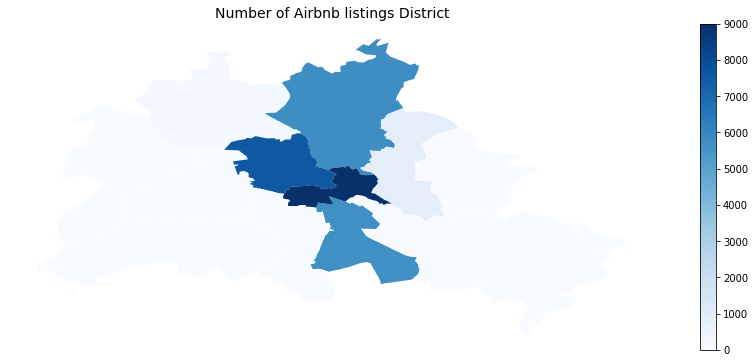

/anaconda3/envs/AirBnB/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


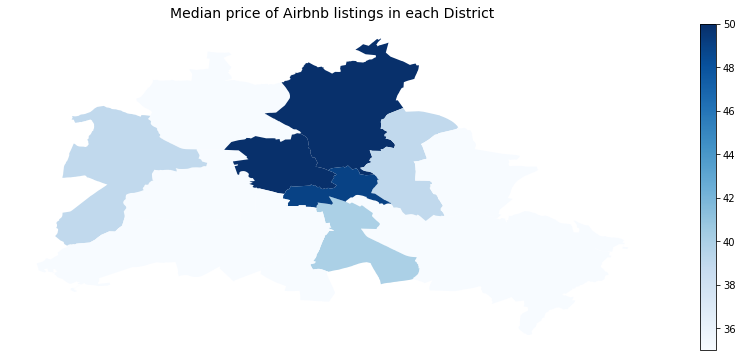

In [51]:
# Plotting the number of listings in each district
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
bezirke_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings District', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each district
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
bezirke_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each District', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(bezirke_map_df.median_price), vmax=max(bezirke_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

Nun werden die Kategorisierten Variablen umgewandelt (one-hot encoding)

In [52]:
transformed_df = pd.get_dummies(dataset)

In [53]:
attributes = transformed_df.shape[1]
features = transformed_df.shape[0]
print(attributes)
print(features)

53
22503


Nun haben wir 53 Attribute und 22503 Features. (Zuvor 35 und 22503). Man kann eventuell noch auf multi-collinearity testen, aber dazu habe ich jetzt keine Lust.

In [55]:
# save 
transformed_df.to_csv('Berlin_cleaned.csv')

### The Location Attribute

Hierfür wird für jedes AirBnB die Entfernung in Minuten zum fünft-nähesten Amenity (Cafe, Pub, Restaurant oder Supermarkt) gemessen. Das Attribut berücksichtigt neben Gehminuten auch Pendlerzeiten. Hierfür wird Pandana in Kombination mit UrbanAccess verwendet. Urban Access ermöglicht es ein Graphen-Netzwerk zuerstellen, in dem ein Pedestrian (Basierend auf OSM-Daten) und ein Pendler-Netzwerk (Basierend auf den GTFS-Feeds von Berlin) kombiniert werden. Auf Basis dieses Graphen, kann anschließend mit Hilfe von Pandana die Erreichbarkeitsanalyse durchgeführt werden.

In [9]:
# Add GTFS feeds from berlin
feeds.to_dict()
feeds.add_feed(add_dict={'vbb': 'https://www.vbb.de/media/download/2029'})
gtfsfeeds.download()

ValueError: vbb passed in add_dict already exists in gtfs_feeds. Only unique keys are allowed to be added.

In [10]:
# load feeds
bbox = (13.08835, 52.33826, 13.76116, 52.67551)
bbox_mitte = (13.296857,52.472924,13.462687,52.570473)


validation = True
verbose = True
remove_stops_outsidebbox = True
append_definitions = True


loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation=validation,
                                           verbose=verbose,
                                           bbox=bbox,
                                           remove_stops_outsidebbox=remove_stops_outsidebbox,
                                           append_definitions=append_definitions)

GTFS text file header whitespace check completed. Took 6.13 seconds
--------------------------------
Processing GTFS feed: vbb
GTFS feed: vbb, calendar_dates uses the same service_id across multiple agency_ids. This feed calendar_dates table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: vbb, calendar uses the same service_id across multiple agency_ids. This feed calendar table will be modified from its original format to provide service_ids for each agency using a one to many join
GTFS feed: vbb, stops uses the same stop_id across multiple agency_ids. This feed stops table will be modified from its original format to provide stop_ids for each agency using a one to many join
agency.txt agency_name column has more than one agency name listed. Unique agency id was assigned using the agency id and associated agency name.
Unique agency id operation complete. Took 77.76 seconds
Unique GTFS feed id operation complete. Took

Nun muss der Zeitpunkt gewählt werden, für welchen die Verbidungen im Pendler-Netzwerk genutzt werden können. 
Hier wurde Montag 07:00 - 10:00 gewählt, da an einem Wochentag mitten im Berufsverkehr wohl die meisten Verbindungen zur Verfügung stehen

In [11]:
ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='monday',
                                   timerange=['07:00:00', '10:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
901 service_ids were extracted from calendar
61,942 trip(s) 26.11 percent of 237,198 total trip records were found in calendar for GTFS feed(s): ['vbb']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
61,942 of 237,198 total trips were extracted representing calendar day: monday. Took 0.60 seconds
There are no departure time records missing from trips following monday schedule. There are no records to interpolate.
Difference between stop times has been successfully calculated. Took 14.94 seconds
Stop times from 07:00:00 to 10:00:00 successfully select

Nun zum Pedestrian-Network, hierfür wird das Straßennetzwerk von OSM benutzt

In [12]:
urbanaccess_net = ua.network.ua_network

In [13]:
nodes, edges = ua.osm.load.ua_network_from_bbox(bbox=bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](52.33826000,13.08835000,52.67551000,13.76116000);>;);out;'}"
Downloaded 115,013.5KB from www.overpass-api.de in 22.21 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 24.82 seconds
Returning OSM data with 707,639 nodes and 200,739 ways...
Edge node pairs completed. Took 439.29 seconds
Returning processed graph with 264,221 nodes and 746,448 edges...
Completed OSM data download and Pandana node and edge table creation in 483.52 seconds
checking for low connectivity nodes...
653 out of 264,221 nodes (0.25 percent of total) were identified as having low connectivity and have been removed.
Completed OSM data download and graph node and edge table

In [14]:
ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.02 seconds


In [15]:
# combine the two
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=False)

Loaded UrbanAccess network components comprised of:
     Transit: 9,085 nodes and 177,681 edges;
     OSM: 263,568 nodes and 744,986 edges
Connector edges between the OSM and transit network nodes successfully completed. Took 4.49 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 15.21 seconds
Network edge and node network integration completed successfully resulting in a total of 272,653 nodes and 940,837 edges:
     Transit: 9,085 nodes 177,681 edges;
     OSM: 263,568 nodes 744,986 edges; and
     OSM/Transit connector: 18,170 edges.


In [16]:
urbanaccess_net.net_edges[urbanaccess_net.net_edges['net_type'] == 'transit'].head()


access area bridge  distance est_width  \
0    nan  nan    nan       NaN       nan   
1    nan  nan    nan       NaN       nan   
2    nan  nan    nan       NaN       nan   
3    nan  nan    nan       NaN       nan   
4    nan  nan    nan       NaN       nan   

                                           from  hgv highway  \
0  710009220008_odeg_ostdeutsche_eisenbahn_gmbh  nan     nan   
1  710009230001_odeg_ostdeutsche_eisenbahn_gmbh  nan     nan   
2  710009220008_odeg_ostdeutsche_eisenbahn_gmbh  nan     nan   
3  710009230001_odeg_ostdeutsche_eisenbahn_gmbh  nan     nan   
4  710009053301_odeg_ostdeutsche_eisenbahn_gmbh  nan     nan   

                                       edge_id junction  ...  \
0  100940043_odeg_ostdeutsche_eisenbahn_gmbh_1      nan  ...   
1  100940043_odeg_ostdeutsche_eisenbahn_gmbh_2      nan  ...   
2  100940055_odeg_ostdeutsche_eisenbahn_gmbh_1      nan  ...   
3  100940055_odeg_ostdeutsche_eisenbahn_gmbh_2      nan  ...   
4  100940060_odeg_ostdeutsche_eisenbahn_gmbh_1      nan  ...   

                                             to toll tunnel  \
0  710009230001_odeg_ostdeutsche_eisenbahn_gmbh  nan    nan   
1  710009053301_odeg_ostdeutsche_eisenbahn_gmbh  nan    nan   
2  710009230001_odeg_ostdeutsche_eisenbahn_gmbh  nan    nan   
3  710009053301_odeg_ostdeutsche_eisenbahn_gmbh  nan    nan   
4  710009230001_odeg_ostdeutsche_eisenbahn_gmbh  nan    nan   

                  unique_agency_id                            unique_route_id  \
0  odeg_ostdeutsche_eisenbahn_gmbh  16345_100_odeg_ostdeutsche_eisenbahn_gmbh   
1  odeg_ostdeutsche_eisenbahn_gmbh  16345_100_odeg_ostdeutsche_eisenbahn_gmbh   
2  odeg_ostdeutsche_eisenbahn_gmbh  16345_100_odeg_ostdeutsche_eisenbahn_gmbh   
3  odeg_ostdeutsche_eisenbahn_gmbh  16345_100_odeg_ostdeutsche_eisenbahn_gmbh   
4  odeg_ostdeutsche_eisenbahn_gmbh  16345_100_odeg_ostdeutsche_eisenbahn_gmbh   

                              unique_trip_id  weight  width from_int to_int  
0  100940043_odeg_ostdeutsche_eisenbahn_gmbh     3.5    nan     1371   1372  
1  100940043_odeg_ostdeutsche_eisenbahn_gmbh     4.8    nan     1372   1370  
2  100940055_odeg_ostdeutsche_eisenbahn_gmbh     3.4    nan     1371   1372  
3  100940055_odeg_ostdeutsche_eisenbahn_gmbh     4.8    nan     1372   1370  
4  100940060_odeg_ostdeutsche_eisenbahn_gmbh     5.2    nan     1370   1372  

[5 rows x 29 columns]

In [17]:
# Save to Disc
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='final_Berlin.h5',
                        overwrite_key=True)

Using existing data/final_Berlin.h5 hdf5 store.
Existing edges overwritten in data/final_Berlin.h5 hdf5 store.
Using existing data/final_Berlin.h5 hdf5 store.
Existing nodes overwritten in data/final_Berlin.h5 hdf5 store.


In [3]:
# load network
# filepath to network
urbanaccess_net = ua.network.load_network(filename='final_Berlin.h5')

Successfully read store: data/final_Berlin.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/final_Berlin.h5 with the following keys: ['/edges', '/nodes']


Figure created. Took 211.58 seconds


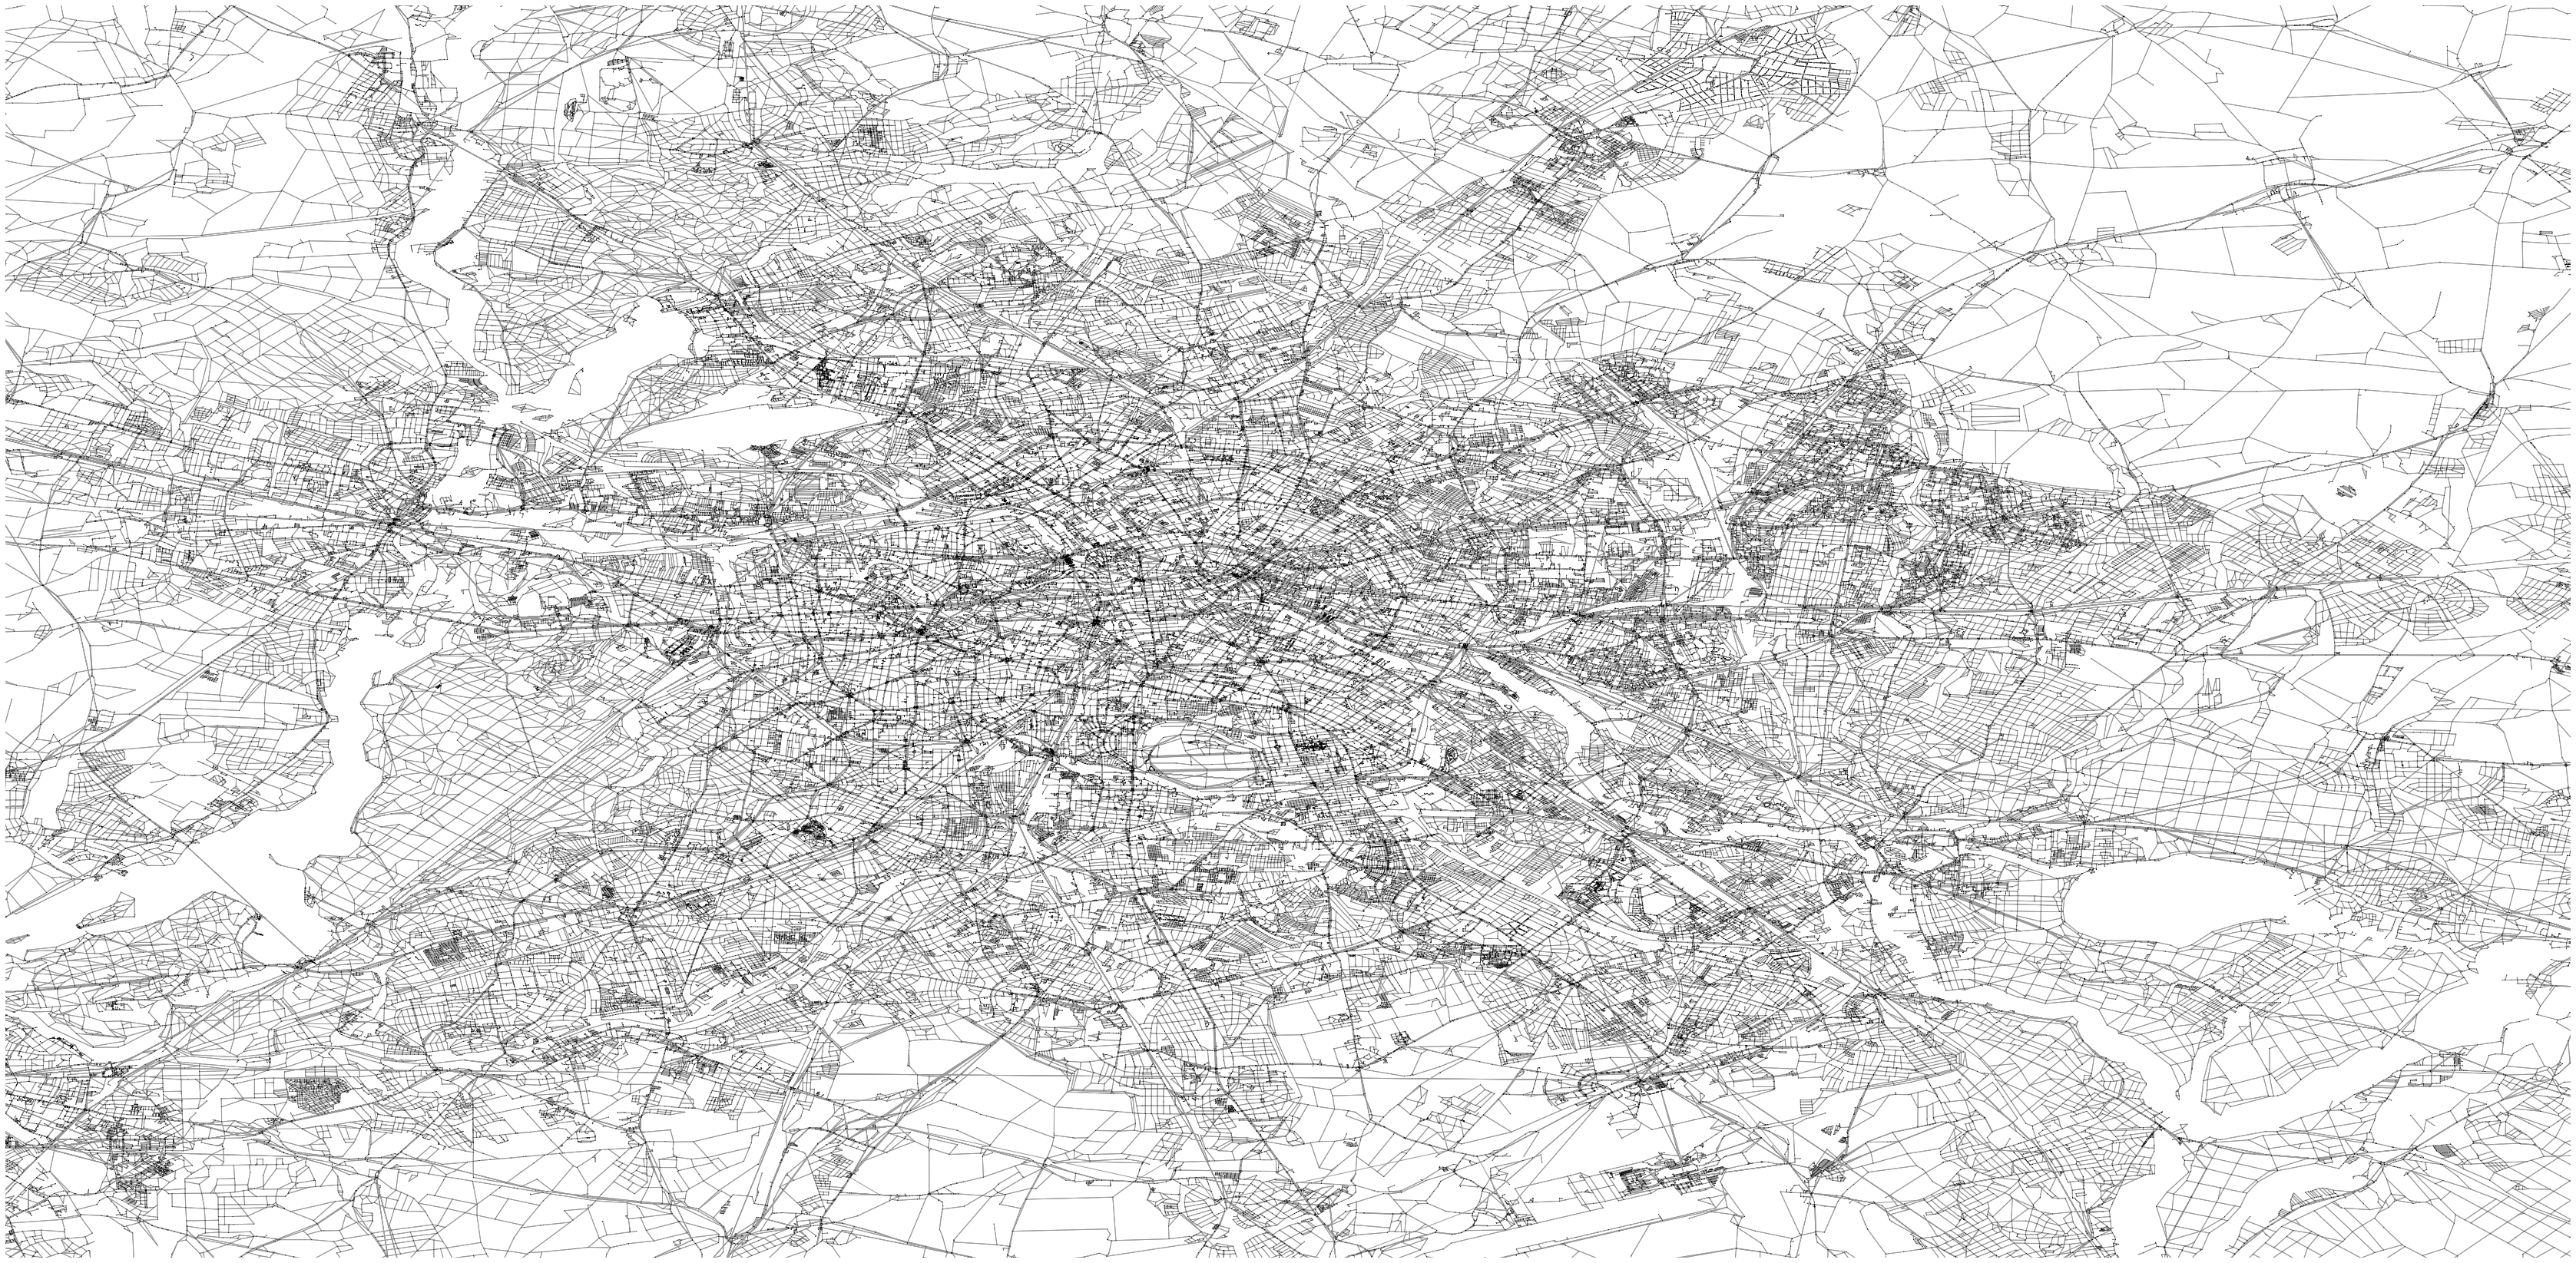

(<Figure size 4309.18x2160 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b3782fdd0>)

In [4]:
# Plot Network
%matplotlib inline
bbox = (13.08835, 52.33826, 13.76116, 52.67551)

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [18]:
# Calculate Headway-Times (Mean)
ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['07:00:00','10:00:00'])

Stop times from 07:00:00 to 10:00:00 successfully selected 187,123 records out of 1,098,999 total records (17.03 percent of total). Took 0.21 seconds
Starting route stop headway calculation for 13,807 route stops...
Route stop headway calculation complete. Took 48.47 seconds
headway calculation complete. Took 51.88 seconds


In [19]:
loaded_feeds.headways.head()

count  mean        std   min   25%   50%   75%   max  \
186911    5.0  33.4  18.622567  13.0  13.0  47.0  47.0  47.0   
186913    5.0  33.4  18.622567  13.0  13.0  47.0  47.0  47.0   
186914    5.0  33.4  18.622567  13.0  13.0  47.0  47.0  47.0   
186915    5.0  33.4  18.622567  13.0  13.0  47.0  47.0  47.0   
186917    5.0  33.4  18.622567  13.0  13.0  47.0  47.0  47.0   

                  unique_stop_id        unique_route_id  \
186911  000008010041_db_regio_ag  19045_100_db_regio_ag   
186913  000008010041_db_regio_ag  19045_100_db_regio_ag   
186914  000008010041_db_regio_ag  19045_100_db_regio_ag   
186915  000008010041_db_regio_ag  19045_100_db_regio_ag   
186917  000008010041_db_regio_ag  19045_100_db_regio_ag   

                                         node_id_route  
186911  000008010041_db_regio_ag_19045_100_db_regio_ag  
186913  000008010041_db_regio_ag_19045_100_db_regio_ag  
186914  000008010041_db_regio_ag_19045_100_db_regio_ag  
186915  000008010041_db_regio_ag_19045_100_db_regio_ag  
186917  000008010041_db_regio_ag_19045_100_db_regio_ag

In [20]:
# Add Headway-Times
ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 9,085 nodes and 177,681 edges;
     OSM: 263,568 nodes and 744,986 edges
routes successfully joined to transit nodes. Took 0.45 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 6.05 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.22 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 19.54 seconds
Network edge and node network integration completed successfully resulting in a total of 277,367 nodes and 1,123,562 edges:
     Transit: 13,799 nodes 177,681 edges;
     OSM: 263,568 nodes 744,986 edges; and
     OSM/Transit connector: 200,895 edges.


In [21]:
# Safe Network
ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='final_Berlin.h5',
                        overwrite_key=True)

Using existing data/final_Berlin.h5 hdf5 store.
Existing edges overwritten in data/final_Berlin.h5 hdf5 store.
Using existing data/final_Berlin.h5 hdf5 store.
Existing nodes overwritten in data/final_Berlin.h5 hdf5 store.


Nun da das Netzwerk steht, kommen wir zur eigentlichen Analyse. Hierfür werden die zuvor aufbereiteten Listings als Dataframe geladen. Weiterhin wurden mit einem externen Script alle Amenities aus Berlin mit Key = restaurant, cafe, pub, supermarket  von OSM gezogen und hier als Dataframe geladen. 

In [56]:
# load network
ua_net = ua.network.load_network(filename='final_Berlin.h5')

Successfully read store: data/final_Berlin.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/final_Berlin.h5 with the following keys: ['/edges', '/nodes']


In [59]:
# Import Listings
Listings_dir = r'./Berlin_Data/Berlin_cleaned.csv'
df_listings = pd.read_csv(Listings_dir)

# Import POIS
amenities_dir = r'./Berlin_Data/amenities_berlin.csv'
df_amenities = pd.read_csv(amenities_dir)

df_amenities['latitude']
# Separate Coordinates from coordinate column into Long and Lat
#df_amanaties[['longitude','latitude']] = df_amanaties.coordinates.str.split(",",expand=True,)

0       52.433668
1       52.413250
2       52.414142
3       52.470656
4       52.448448
          ...    
8343    52.566968
8344    52.632945
8345    52.632262
8346    52.609645
8347    52.605392
Name: latitude, Length: 8348, dtype: float64

In [60]:
# Initialise Pandana Network
s_time = time.time()
transit_ped_net = pdna.Network(ua_net.net_nodes["x"],
                               ua_net.net_nodes["y"],
                               ua_net.net_edges["from_int"],
                               ua_net.net_edges["to_int"],
                               ua_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Took 185.00 seconds


Zunächst werden die POIS(Amenities) im Netzwerk eingetragen und der nähesten Node des Netzwerkes zugeordnet

In [61]:
distance = 20
num_pois = 10

# hier kann man vllt auch die OSM-Rohdaten importieren
transit_ped_net.set_pois('amenities', distance ,num_pois, df_amenities['longitude'], df_amenities['latitude'])

Anschließend wird für jedes Feature aus dem Dataframe Listing die näheste Node gesucht und derren ID wird als neues Attribut um DF hinzugefügt. Dies wird im Weiteren Verlauf benötigt.

In [62]:
# get Node IDS
long = df_listings['longitude']
lat = df_listings['latitude']
df_listings['node_id'] = transit_ped_net.get_node_ids(long, lat)

In [64]:
num_pois = 5
N_nearest_access = transit_ped_net.nearest_pois(distance=distance, category='amenities', num_pois=num_pois)

# Create DF for requested number of POIs
Access_Score = pd.DataFrame(N_nearest_access[5])

# Rename to score
Access = Access_Score.rename(columns={5:'Score'})

# get node_ids fpr POIs
df_amenities['node_id'] = transit_ped_net.get_node_ids(df_amenities['longitude'], df_amenities['latitude'])


In [65]:
Access.reset_index(level=0, inplace=True)

In [67]:
print(Access)
Access = Access.rename(columns={'id_int':'node_id'})

        node_id   Score
0             1   6.950
1             2   5.134
2             3   5.616
3             4  12.212
4             5   5.012
...         ...     ...
277362   277363   6.272
277363   277364   6.595
277364   277365  20.000
277365   277366  20.000
277366   277367  20.000

[277367 rows x 2 columns]


In [102]:
merged = pd.merge(df_listings, Access, on='node_id')

### Normalize Dataset

In [116]:
df_dir = r'./Berlin_Data/Berlin_Listings_Score.csv'
df = pd.read_csv(df_dir)

df.drop('node_id', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('longitude', axis=1, inplace=True)
df.drop('latitude', axis=1, inplace=True)

In [117]:
df.dtypes

Unnamed: 0.1                                               int64
accommodates                                               int64
bathrooms                                                float64
bedrooms                                                 float64
beds                                                     float64
price                                                    float64
security_deposit                                         float64
cleaning_fee                                             float64
guests_included                                            int64
extra_people                                             float64
minimum_nights                                             int64
instant_bookable                                           int64
check_in_24h                                             float64
balcony                                                  float64
bed_linen                                                float64
tv                       

In [118]:
numerical_columns = ['accommodates', 'bathrooms', 'cleaning_fee', 
                     'extra_people', 
                      'price', 'security_deposit']

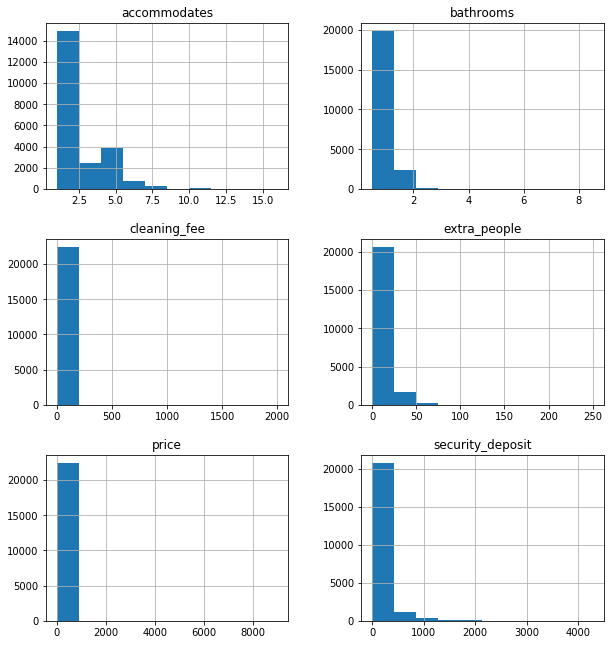

In [119]:
df[numerical_columns].hist(figsize=(10,11));

In [122]:
for col in numerical_columns:
    df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[col] = np.log(df[col])

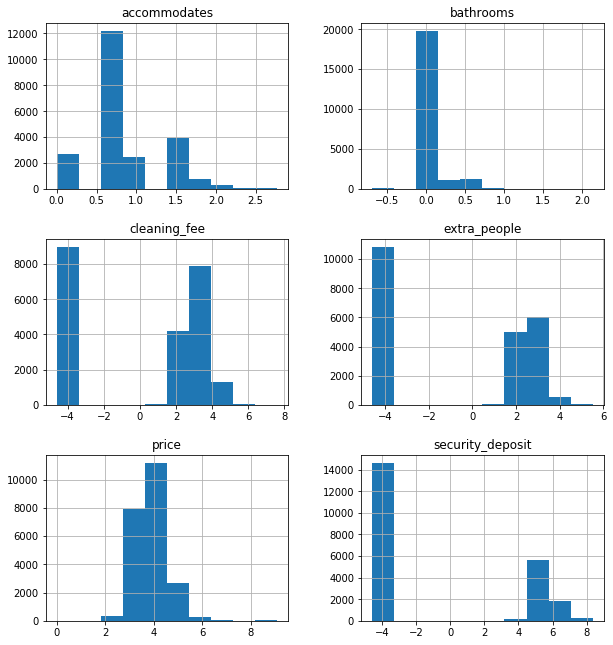

In [123]:
df[numerical_columns].hist(figsize=(10,11));

### The Model

In [129]:
# Separating X and y

df.drop('neighbourhood_group_cleansed_Steglitz - Zehlendorf', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Tempelhof - Schöneberg', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Marzahn - Hellersdorf', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Charlottenburg-Wilm.', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Treptow - Köpenick', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Reinickendorf', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Lichtenberg', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Spandau', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Pankow', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Mitte', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Friedrichshain-Kreuzberg', axis=1, inplace=True)
df.drop('neighbourhood_group_cleansed_Neukölln', axis=1, inplace=True)


X = df.drop('price', axis=1)
y = df.price

In [130]:
# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [131]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [132]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[01:34:49] WARNING: /usr/local/miniconda/conda-bld/xgboost_1566327371504/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.1 minutes

Training MSE: 0.1546
Validation MSE: 0.1758

Training r2: 0.5986
Validation r2: 0.5871


In [133]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

weight
cancellation_policy_moderate                     0.000000
bed_type_Real Bed                                0.000000
bed_type_Couch                                   0.000000
room_type_Private room                           0.000000
property_type_House                              0.000000
instant_bookable                                 0.000000
check_in_24h                                     0.000000
cooking_basics                                   0.001483
internet                                         0.001529
pets_allowed                                     0.001690
coffee_machine                                   0.001701
beds                                             0.002287
balcony                                          0.002765
private_entrance                                 0.002828
host_greeting                                    0.002865
parking                                          0.002967
white_goods                                      0.003581
cancellation_policy_strict_14_with_grace_period  0.003747
bed_linen                                        0.004110
security_deposit                                 0.005269
smoking_allowed                                  0.005297
child_friendly                                   0.006231
long_term_stays                                  0.006530
room_type_Shared room                            0.007066
cancellation_policy_flexible                     0.007239
property_type_Apartment                          0.007791
Unnamed: 0.1                                     0.007954
minimum_nights                                   0.008728
extra_people                                     0.008761
Score                                            0.008931
elevator                                         0.014537
cleaning_fee                                     0.017358
property_type_Other                              0.025392
bathrooms                                        0.028382
guests_included                                  0.029378
tv                                               0.029857
bedrooms                                         0.038955
accommodates                                     0.042261
room_type_Entire home/apt                        0.662532

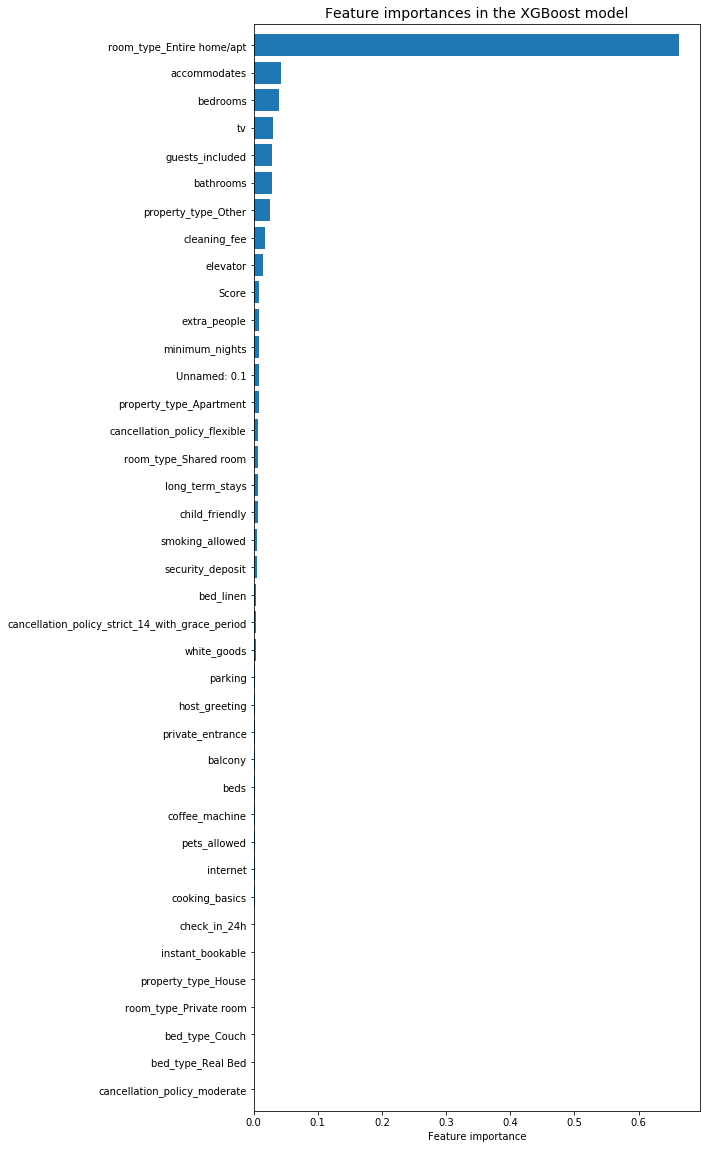

In [134]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()